In [ ]:
pip install opencv-python pycocotools matplotlib onnxruntime onnx

In [2]:
pip install earthengine-api

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install geemap

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install setuptools

  Using cached setuptools-69.2.0-py3-none-any.whl.metadata (6.3 kB)
Using cached setuptools-69.2.0-py3-none-any.whl (821 kB)
Note: you may need to restart the kernel to use updated packages.


# House AI

# Data Pipeline

![Design](/Users/karthikh/dspg/HouseAI/images/RuralGroceryStoreDesigns.png)

In [2]:
import ee
import geemap

ee.Authenticate()
ee.Initialize(project='ee-karthikhanumanthaiah')

In [10]:
using_colab = False

In [11]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib onnx onnxruntime
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.utils.onnx import SamOnnxModel

import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic
from segment_anything import SamAutomaticMaskGenerator
import requests
from requests.structures import CaseInsensitiveDict
import pandas as pd

In [12]:
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [13]:
checkpoint = "./sam_vit_h_4b8939.pth"
model_type = "vit_h"

In [14]:
sam = sam_model_registry[model_type](checkpoint=checkpoint)

In [15]:
onnx_model_path = None

In [16]:
import warnings

onnx_model_path = "sam_onnx_example.onnx"

onnx_model = SamOnnxModel(sam, return_single_mask=True)

dynamic_axes = {
    "point_coords": {1: "num_points"},
    "point_labels": {1: "num_points"},
}

embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    with open(onnx_model_path, "wb") as f:
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )    

In [17]:
ort_session = onnxruntime.InferenceSession(onnx_model_path)

In [49]:
device = torch.device("cpu")
sam.to(device='cpu')
predictor = SamPredictor(sam)

In [19]:
mask_generator1 = SamAutomaticMaskGenerator(sam, points_per_batch=16)

# NAIP: National Agriculture Imagery Program Dataset
https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ

In [3]:
dataset = ee.ImageCollection('USDA/NAIP/DOQQ').filter(ee.Filter.date('2017-01-01', '2023-12-31'))
trueColor = dataset.select(['R', 'G', 'B'])
trueColorVis = {
  min: 0,
  max: 255,
}
m = geemap.Map(center=[42.01397525784132, -93.68376948826881], zoom=18)
m.add_ee_layer(trueColor, trueColorVis, 'True Color')

display(m)


Map(center=[42.01397525784132, -93.68376948826881], controls=(WidgetControl(options=['position', 'transparent_…

# Approach 1: location as prompt
Assumption is we already know the house location

https://earthengine.googleapis.com/v1/projects/ee-karthikhanumanthaiah/thumbnails/de4281ca2756e839fd8d40b67abcae63-496916903ebff55aa9546261588149fc:getPixels


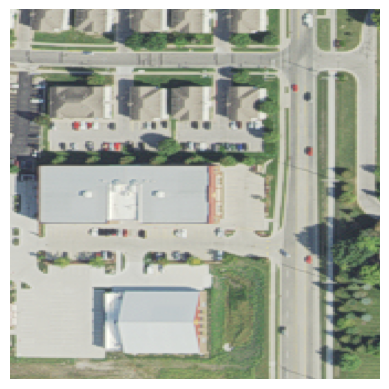

In [56]:
lat = 42.01385846996999
lon = -93.67925617666492
diff = 0.001
roi = ee.Geometry.Rectangle([lon-diff, lat-diff, lon+diff, lat+diff])
start_date = '2017-01-01'
end_date = '2018-12-31'

landsat = ee.ImageCollection('USDA/NAIP/DOQQ').filterBounds(roi).filterDate(start_date, end_date)
landsat_rgb = landsat.select(['R', 'G', 'B']).first()

vis_params = {
  'min': 0,
  'max': 255,
  'bands': ['R', 'G', 'B'],
  'dimensions': (2048, 2048),
  'format': 'jpg',
  'region': roi
}

image_url = landsat_rgb.getThumbUrl(vis_params)
print(image_url)
# Download the image
import urllib.request
urllib.request.urlretrieve(image_url, "landsat_rgb_image.jpg")

# Visualize the downloaded image
image = plt.imread("landsat_rgb_image.jpg")
plt.imshow(image)
plt.axis('off')
plt.show()

# Example Prompt

1024


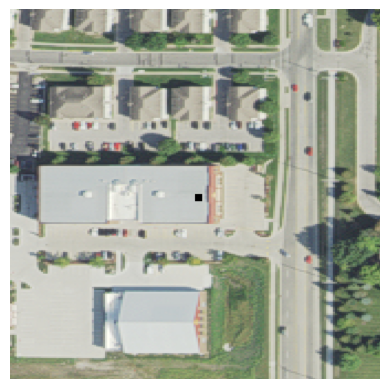

In [64]:
size = int(image.shape[0]/2)
extra = 40
print(size)
image1 = image.copy()
image1[size:size+extra, size:size+extra, 0] = 0
image1[size:size+extra, size:size+extra, 1] = 0
image1[size:size+extra, size:size+extra, 2] = 0
plt.imshow(image1)
plt.axis('off')
plt.show()

In [58]:
predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()
image_embedding.shape

(1, 256, 64, 64)

In [59]:
input_point = np.array([[1024, 1024]])
input_label = np.array([1])
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)
ort_inputs = {
    "image_embeddings": image_embedding,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

In [60]:
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold
masks.shape

(1, 1, 2048, 2048)

# Sample Output - Approach 1

In [96]:
def get_housedata(lat, lon):
  diff = 0.001
  roi = ee.Geometry.Rectangle([lon-diff, lat-diff, lon+diff, lat+diff])
  start_date = '2017-01-01'
  end_date = '2018-12-31'

  landsat = ee.ImageCollection('USDA/NAIP/DOQQ').filterBounds(roi).filterDate(start_date, end_date)
  landsat_rgb = landsat.select(['R', 'G', 'B']).first()

  vis_params = {
    'min': 0,
    'max': 255,
    'bands': ['R', 'G', 'B'],
    'dimensions': (2048, 2048),
    'format': 'jpg',
    'region': roi
  }

  image_url = landsat_rgb.getThumbUrl(vis_params)
  print(image_url)
  # Download the image
  import urllib.request
  urllib.request.urlretrieve(image_url, "landsat_rgb_image1.jpg")

  # Visualize the downloaded image
  image = plt.imread("landsat_rgb_image1.jpg")
  predictor.set_image(image)
  image_embedding = predictor.get_image_embedding().cpu().numpy()
  image_embedding.shape
  input_point = np.array([[800, 1024], [1024, 1024]])
  input_label = np.array([1,2])
  onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
  onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)

  onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)
  onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
  onnx_has_mask_input = np.zeros(1, dtype=np.float32)
  ort_inputs = {
      "image_embeddings": image_embedding,
      "point_coords": onnx_coord,
      "point_labels": onnx_label,
      "mask_input": onnx_mask_input,
      "has_mask_input": onnx_has_mask_input,
      "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
  }
  masks, _, low_res_logits = ort_session.run(None, ort_inputs)
  masks = masks > predictor.model.mask_threshold
  masks.shape
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  show_mask(masks, plt.gca())
  show_points(input_point, input_label, plt.gca())
  plt.axis('off')
  plt.show()

https://earthengine.googleapis.com/v1/projects/ee-karthikhanumanthaiah/thumbnails/de4281ca2756e839fd8d40b67abcae63-6dae06ba0c0ab29c3a1d8854d1dcd7b7:getPixels


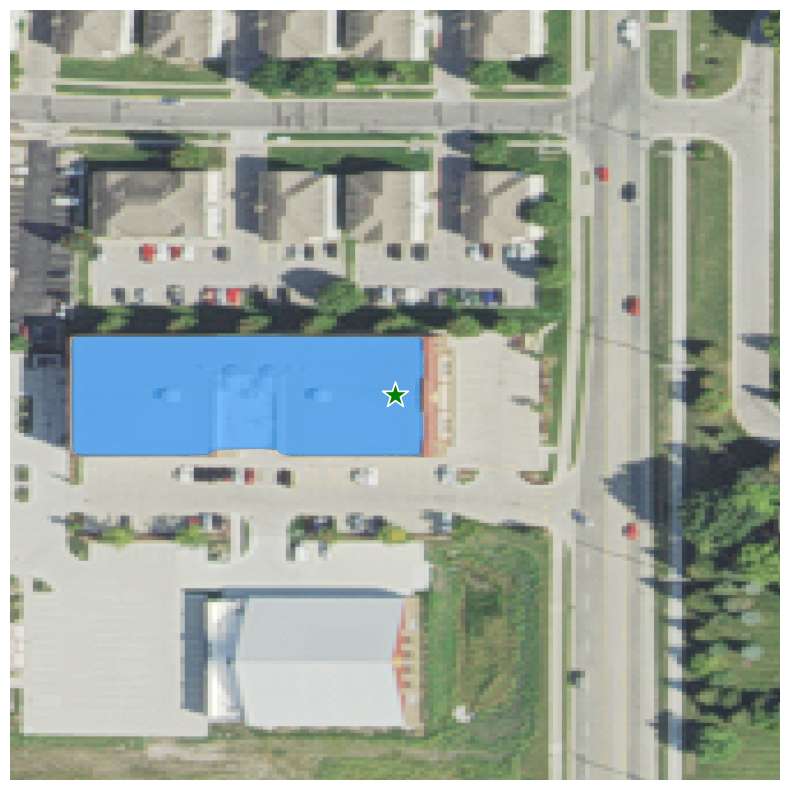

In [68]:
lat = 42.01385846996999
lon = -93.67925617666492
get_housedata(lat, lon)

# Low quality prompt, image

https://earthengine.googleapis.com/v1/projects/ee-karthikhanumanthaiah/thumbnails/d6276aaadb188e0ff6ea1c8add6e26d1-e13c1085a74bb7baf60a598327e8067b:getPixels


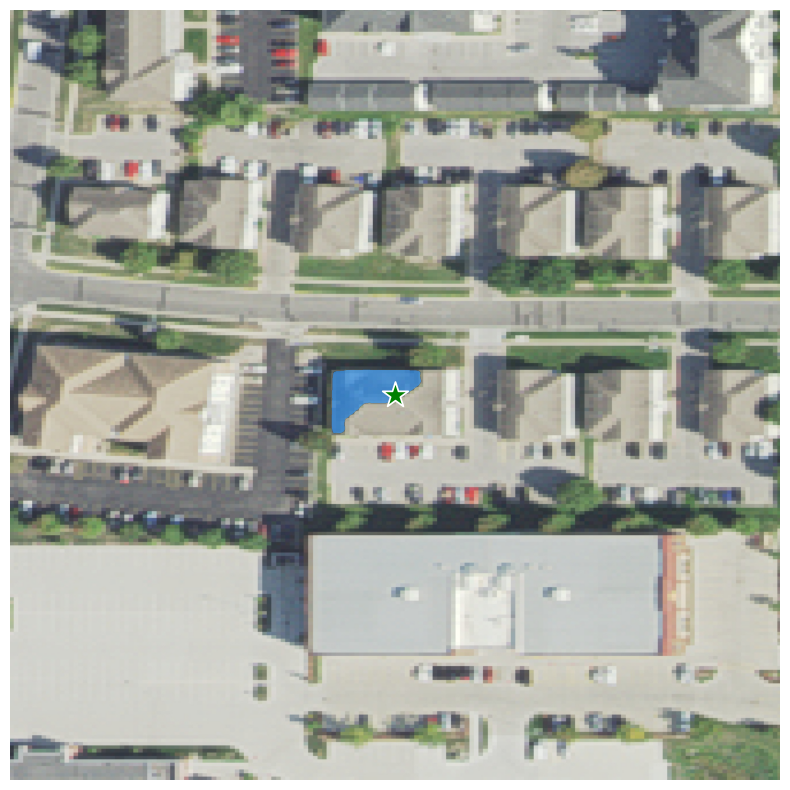

In [70]:
lat = 42.01437369795494
lon = -93.67988768808686
get_housedata(lat, lon)

# Effect of higher resolution prompts

https://earthengine.googleapis.com/v1/projects/ee-karthikhanumanthaiah/thumbnails/2633c9040bee2ecb3a61e8937adaf6a0-69ea680db9e118e75bcc0cfea1f8d689:getPixels


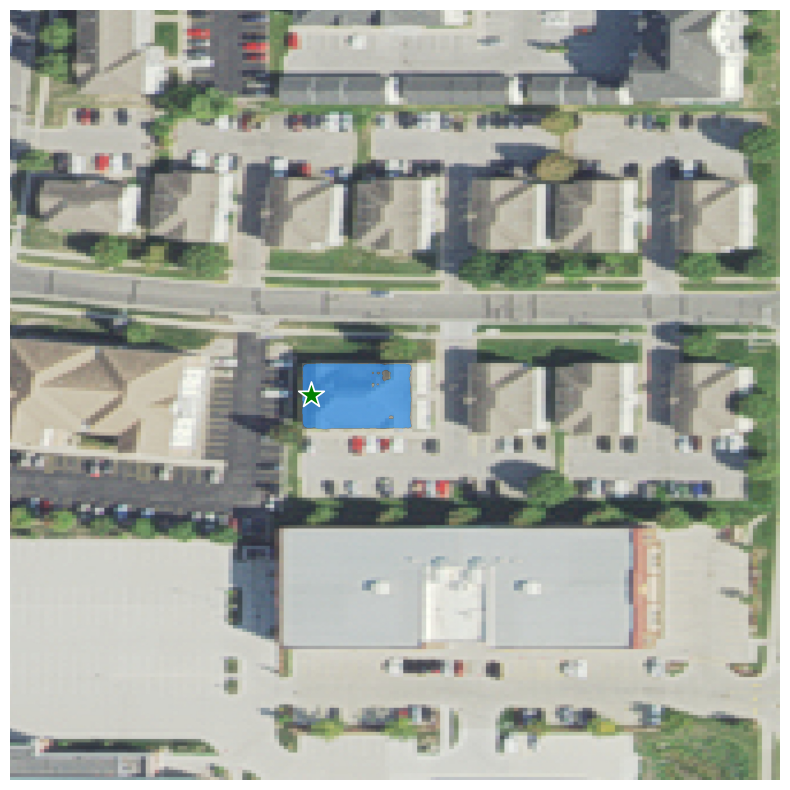

In [97]:
lat = 42.014356909124245
lon = -93.67981073618598
get_housedata(lat, lon)

In [21]:
masks = mask_generator1.generate(image)

# Approch 2 - No prompts

In [22]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

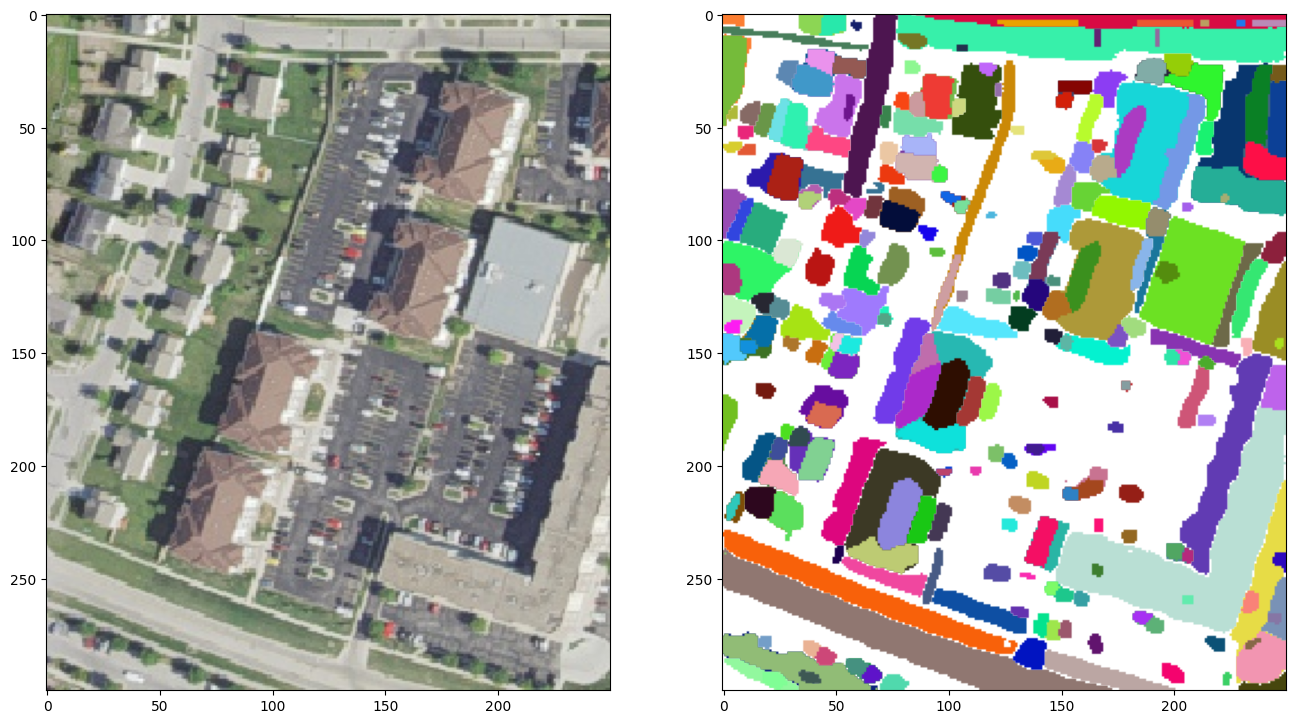

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs[0].imshow(image)
show_anns(masks, axs[1])

# Effect if higher resolution image

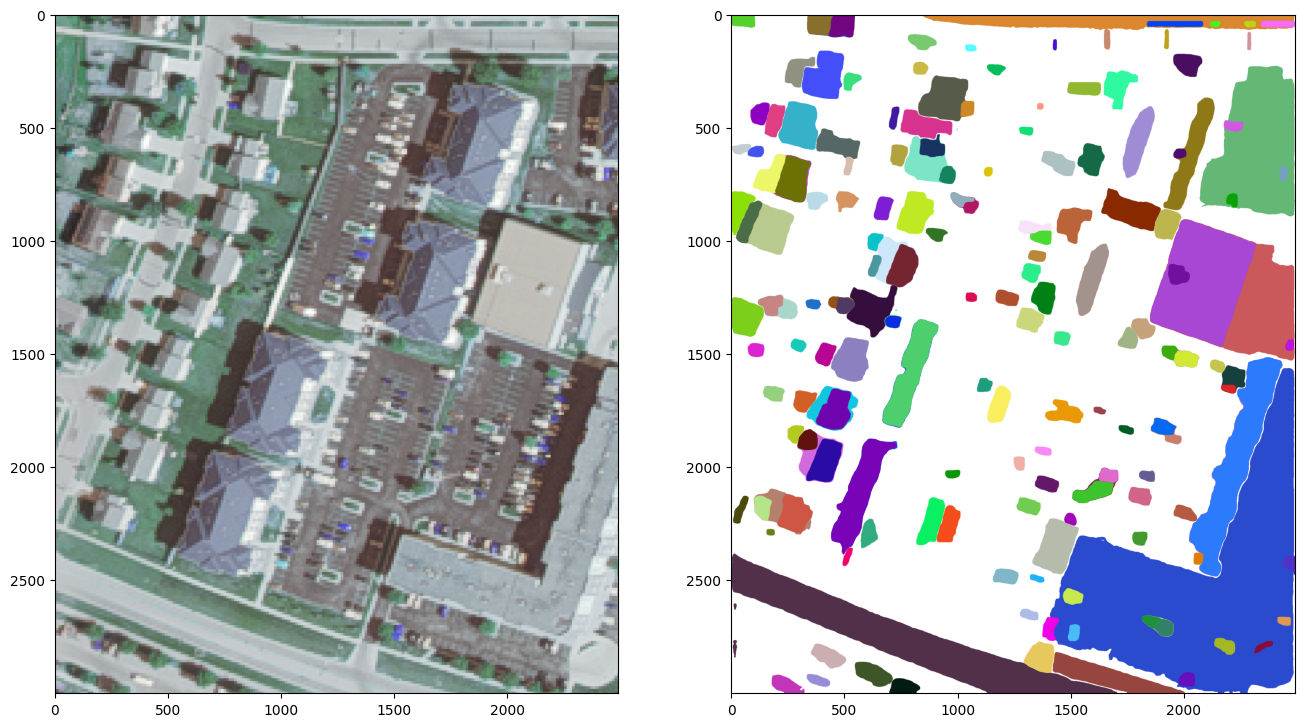

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs[0].imshow(image_information)
show_anns(masks, axs[1])

# Metadata extraction

In [84]:
categories = ['education','commercial.supermarket','leisure.park','healthcare','accommodation','activity','commercial.gas','catering.restaurant','public_transport']
url = "https://api.geoapify.com/v2/places"
diff = 0.01
roi = [lon-diff, lat-diff, lon+diff, lat+diff]
print('rect:{0}'.format(','.join(map(str, roi))))
params = {
    'categories': ','.join(categories),
    'filter': 'rect:{0}'.format(','.join(map(str, roi))),
    'apiKey':'cc2a0b374bf6426fbca4c86995ed1624'
}
headers = CaseInsensitiveDict()
headers["Accept"] = "application/json"

resp = requests.get(url, headers=headers, params=params)

print(resp.status_code)


rect:-93.68988768808687,42.00437369795494,-93.66988768808686,42.024373697954935
200


In [85]:
df = pd.DataFrame({'features':[], 'name':[]})
result = resp.json()
for feature in result['features']:
  if 'name' in feature['properties']:
    intersection = list(set(feature['properties']['categories']) & set(categories))
    df.loc[len(df)] = [''.join(intersection),feature['properties']['name']]

print(df.sort_values(by='features'))

                  features                                          name
14           accommodation                             Hilton Garden Inn
10           accommodation                                     Sleep Inn
3      catering.restaurant                                 Daytime Diner
15     catering.restaurant                                   Joe's Pizza
1   commercial.supermarket                                        Hy-Vee
5   commercial.supermarket                        Ames Asian Market West
12               education                            Ames Middle School
4               healthcare                               Hy-Vee Pharmacy
11              healthcare                   Israel Family Hospice House
0             leisure.park                                    Daley Park
2             leisure.park                      Christopher Gartner Park
17        public_transport     Mortensen Road at Coconino Road Eastbound
16        public_transport      Mortensen Road at D

# Next Options

![Design](/Users/karthikh/dspg/HouseAI/images/RuralGroceryStoreDesigns_Nxt.png)